In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
import statsmodels.api as sm
import scipy.stats as stats

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import lars_path
np.random.seed = 100

In [3]:
plt.rcParams.update({'font.size': 14})

**Notebook Contents**

> 1. Loading and formatting data
> 2. Feature selection - by hand and with lasso regularization
> 3. Comparing lasso and ElasticNet results
> 4. Final model validation and results


## 1. Loading and formatting data

In [4]:
philly_cars = pd.read_csv('philly_dec2021.csv')
nyc_cars = pd.read_csv('nyc_dec2021.csv')


In [5]:
cars = nyc_cars

In [6]:
# removing rare engine category
cars = cars[cars['cylinders']<12]

In [7]:
# philly_cars['city'] = 0
# nyc_cars['city'] = 1
# cars = nyc_cars.append(philly_cars)

# # fill in any feature values unique to one city df
# cars = cars.fillna(0)

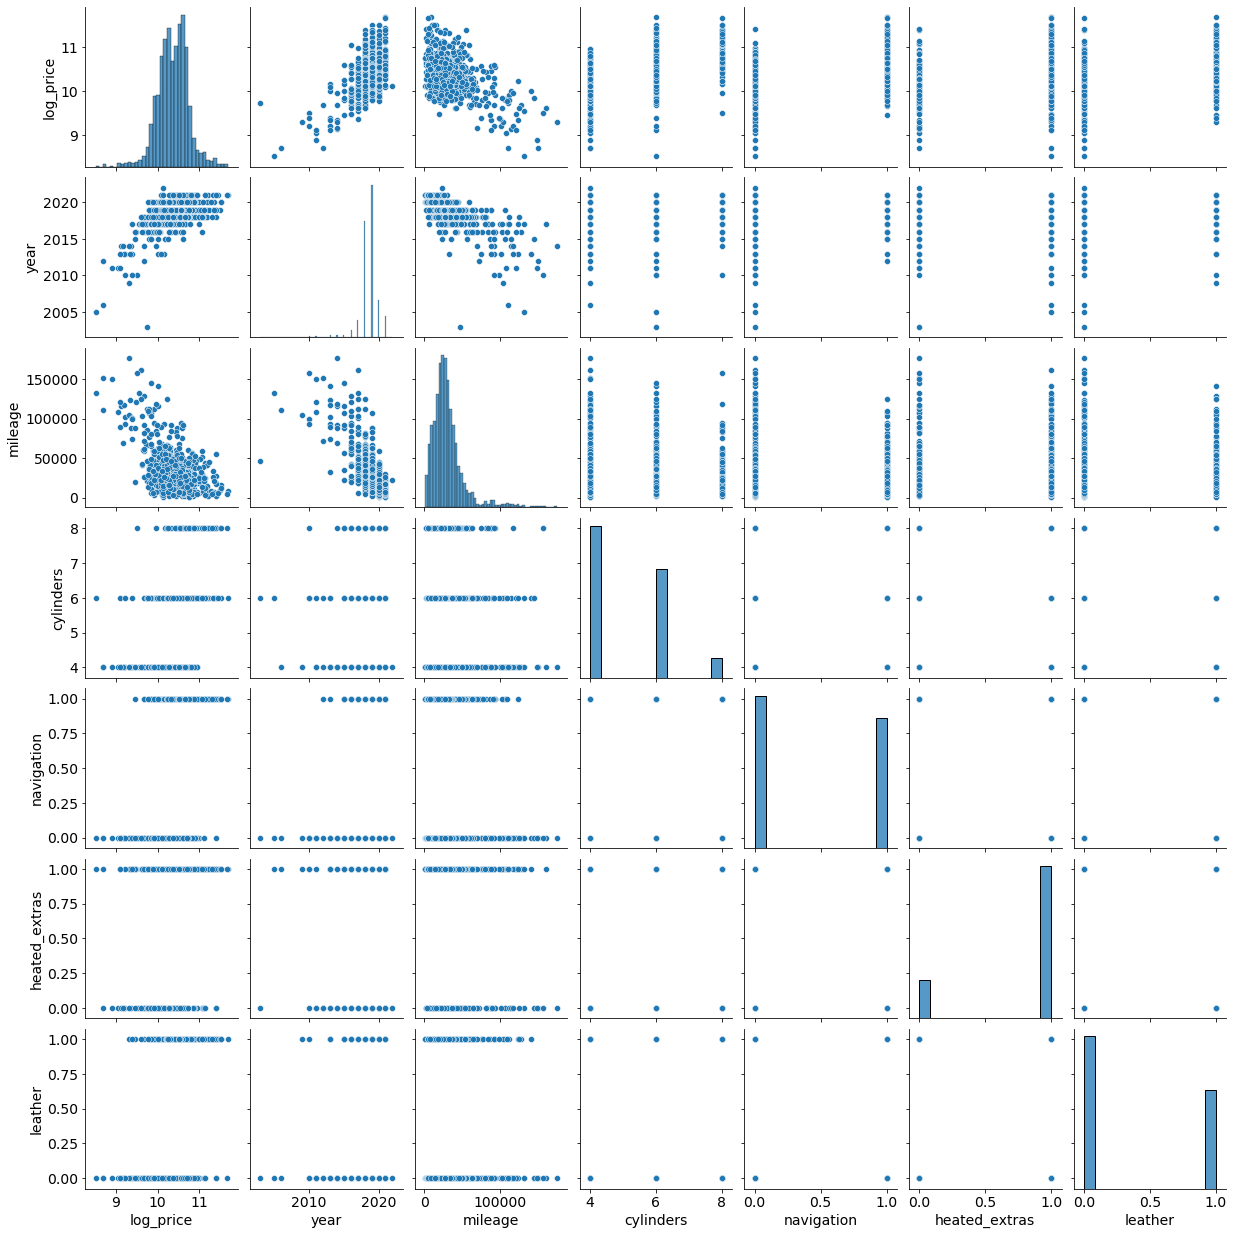

In [8]:
sns.pairplot(cars[['log_price', 'year', 'mileage', 'cylinders', 'navigation', 'heated_extras', 
                    'leather']])

## 2. Feature selection and Lasso regularization

In [9]:
def standardize(X_train, X_test):
    std = StandardScaler()
    std.fit(X_train)

    X_train = std.transform(X_train)
    X_test = std.transform(X_test)

    return(X_train, X_test)

In [10]:
def optimize_ElasticNet(X_train, y_train, X_val, y_val, alphavec = 10**np.linspace(-5,2,200)):
    
    en_model = ElasticNetCV(alphas = alphavec, l1_ratio=np.linspace(0.01,0.99,20), cv=5, 
                            max_iter = 10000, fit_intercept=True)
    en_model.fit(X_train, y_train)
    
    R2 = en_model.score(X_val, y_val)
    predictions = en_model.predict(X_val)

    print("alpha range: [%f, %f]"%(alphavec[0], alphavec[-1]))
    print("best alpha: %.4f"%(en_model.alpha_))
    print("l1_ratio: %.4f"%(en_model.l1_ratio_))
    print("R^2: %.4f"%(R2))
    print("Adj. R^2: %.4f"%(adj_r2(R2, X_train.shape[0], X_train.shape[1])))
    print("RMSE: %.4f"%(np.sqrt(mean_squared_error(y_val, predictions))))
    
    return en_model

In [11]:
def feature_coefs(X, model):
    coefs= pd.DataFrame(zip(X.columns, model.coef_)).set_index(0)

    coefs['abs_val'] = coefs[1].apply(np.abs)
    sorted_coefs = coefs[coefs['abs_val']>0].sort_values(by='abs_val', ascending=False)
    sorted_coefs = sorted_coefs.rename(columns = {1: 'coef'})
    sorted_coefs['price_ratio'] = sorted_coefs['coef'].apply(np.exp)
    
    return sorted_coefs
    

In [12]:
def residual_plots(y, pred):
    plt.figure(figsize=(20,5))

    plt.subplot(1, 3, 1)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 2)
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")
    

In [13]:
def adj_r2(r2, n, p):
    # Calculates adjusted R^2 from R^2.
    # n: number of samples
    # p: number of features
    
    return 1-(1-r2)*(n-1)/(n-p-1)

In [14]:
def lasso_pipeline(X_train, y_train, X_val, y_val):
    # cross validation to choose optimal alpha value
    # predictions and scoring on validation set
    
    def optimize_lasso(X_train, y_train):
        
        alphavec = 10**np.linspace(-4,2,200)
        print("alpha range: [%f, %f]"%(alphavec[0], alphavec[-1]))
        
        lasso_model = LassoCV(alphas = alphavec, cv=5, fit_intercept=True, max_iter=10000)
        lasso_model.fit(X_train, y_train)

        return lasso_model

    def report_scores(model, sorted_coefs, X_val=X_val, y_val=y_val):
        
        predictions = lasso_model.predict(X_val)
        R2 = lasso_model.score(X_val, y_val)

        print("best alpha: %.4f"%(lasso_model.alpha_))
        print("R^2: %.4f"%(R2))
        print("Adj. R^2: %.4f"%(adj_r2(R2, X_val.shape[0], len(sorted_coefs))))
        print("RMSE: %.4f"%(np.sqrt(mean_squared_error(y_val, predictions))))
        print("Number of features: %i"%(len(sorted_coefs)))
            
        return predictions
        
        
    lasso_model = optimize_lasso(X_train, y_train) # LassoCV search for optimal lambda
    sorted_coefs = feature_coefs(X, lasso_model) # sort named coefficients by magnitude
    
    predictions = report_scores(lasso_model, sorted_coefs) # reporting on optimized model
    
    # plot residuals and Q-Q plot
    residual_plots(y_val, predictions)

    return (lasso_model, sorted_coefs, predictions)


In [15]:
# dropping redundant, irrelevant or collinear columns from the cars df
X = cars.drop(['price', 'log_price', 'price_diff', 'log_price_diff', 'damage', 'options', 'engine', 
               'color', 'model', 'history', 'wheel_size', 'location', 'capacity', 'num_options',
               '1sd_package'], axis=1)
X = X.drop(X.filter(like='inch_wheels').columns, axis=1)

In [16]:
# dropping binary columns that correlate 100% with 'make', since they are not generalizable
options_by_make = X.groupby(['make']).sum().iloc[:,8:]
company_options = options_by_make.columns[options_by_make.sum(axis=0) == options_by_make.max(axis=0)]
X = X.drop(list(company_options), axis=1)

In [17]:
# dropping car make, just coding whether brand is 'luxury' or not
X = X.drop(X.filter(like='make').columns, axis=1)

In [18]:
# coding number of engine cylinders as categorical
X['cylinders'] = X['cylinders'].astype(str)

In [19]:
X = X.drop(['index'], axis=1)

In [20]:
X = pd.get_dummies(X, drop_first=True)

In [21]:
y = cars['log_price']

In [22]:
# holding out test data and scaling features

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)

_, X_val = standardize(X_train, X_val)
X_train, X_test = standardize(X_train, X_test)


In [23]:
# Using lasso regularization to get a first idea of the most informative features

alpha range: [0.000100, 100.000000]
best alpha: 0.0052
R^2: 0.8505
Adj. R^2: 0.8057
RMSE: 0.1412
Number of features: 65


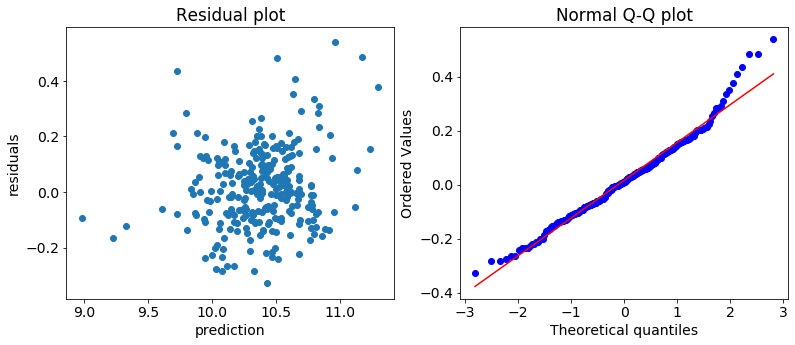

In [24]:
lasso_model, sorted_coefs, _ = lasso_pipeline(X_train, y_train, X_val, y_val)


Text(0.5, 0, 'coefficients')

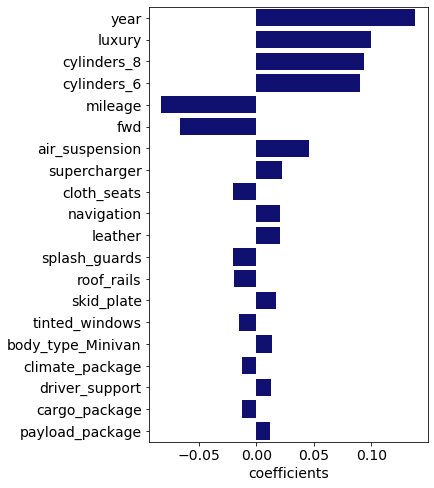

In [25]:
# Visual guide to feature influence in the model

plt.figure(figsize=(5,8))
sc = sorted_coefs[:20]
sns.barplot(data=sc, y=sc.index, x=sc['coef'], color='navy')
plt.ylabel('')
plt.xlabel('coefficients')

In [26]:
sorted_coefs.index.names = ['']
sorted_coefs = sorted_coefs.drop('abs_val', axis=1)
sorted_coefs['gain/loss per $1'] = np.round(sorted_coefs['price_ratio']-1,2)
np.round(sorted_coefs[:20], 3)


,coef,price_ratio,gain/loss per $1
,,,
year,0.138,1.148,0.15
luxury,0.099,1.104,0.10
cylinders_8,0.094,1.098,0.10
cylinders_6,0.090,1.094,0.09
mileage,-0.083,0.921,-0.08
fwd,-0.067,0.935,-0.06
air_suspension,0.046,1.047,0.05
supercharger,0.022,1.022,0.02
cloth_seats,-0.021,0.979,-0.02


In [27]:
# There are still many uninformative features, so I will try increasing lasso regularization

higher_alpha = 0.015
lasso_model_higher_reg = Lasso(alpha=higher_alpha, fit_intercept=True)

R2 = cross_val_score(lasso_model_higher_reg, X_train, y_train, cv=5, scoring='r2').mean()
RMSE = np.sqrt(-cross_val_score(lasso_model_higher_reg, X_train, y_train, cv=5, 
                       scoring='neg_mean_squared_error')).mean()


print('R^2: %.4f'%(R2))
print('Adj. R^2: %.4f'%(adj_r2(R2, X_train.shape[0], X_train.shape[1])))
print('RMSE: %.4f'%(RMSE))


R^2: 0.7926
Adj. R^2: 0.7424
RMSE: 0.1726


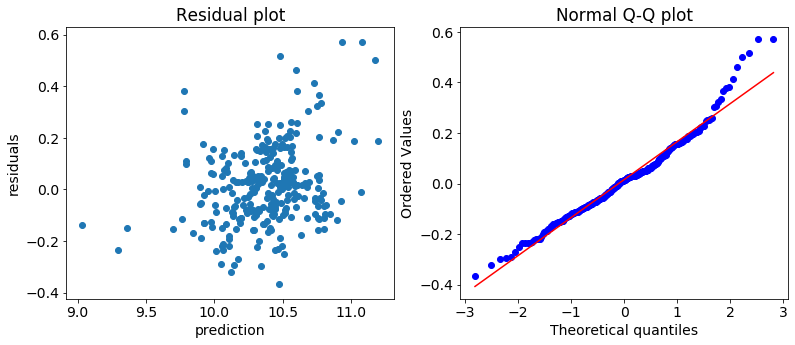

In [28]:
lasso_model_higher_reg.fit(X_train, y_train)

predictions = lasso_model_higher_reg.predict(X_val)

residual_plots(y_val, predictions)

In [29]:
sorted_coefs = feature_coefs(X, lasso_model_higher_reg)
print("Number of features: %i"%(len(sorted_coefs)))

Number of features: 29


Text(0.5, 0, 'coefficients')

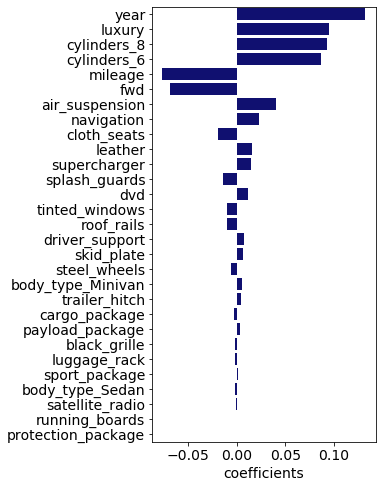

In [30]:
plt.figure(figsize=(4,8))
sns.barplot(data=sorted_coefs, y=sorted_coefs.index, x=sorted_coefs['coef'], color='navy')
plt.ylabel('')
plt.xlabel('coefficients')

In [31]:
# Checking Lasso path across alpha values to visualize feature importance

alphas, _, coefs = lars_path(X_train, y_train, method='lasso')

In [32]:
# highlighting top 10 features

top_features = pd.DataFrame(np.abs(coefs)).sort_values(by=30, ascending=False).index[:10]
mask = np.ones((np.shape(coefs)[0],))
mask[top_features] = 0
mask = np.where(mask)[0]

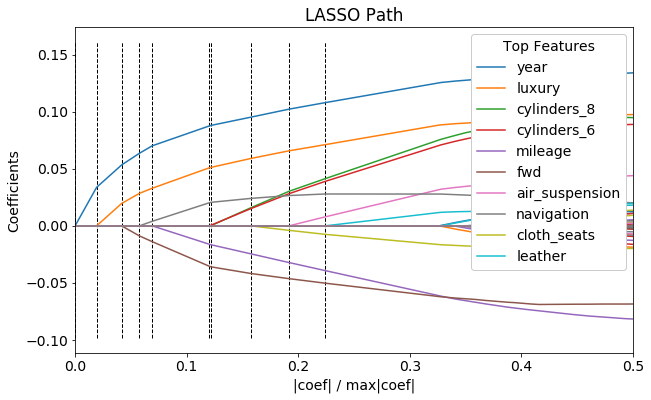

In [33]:
# plotting regularization path

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10,6))
plt.plot(xx, coefs[top_features,:].T)
ymin, ymax = plt.ylim()
plt.vlines(xx[:10], ymin, ymax, linestyle='dashed', color='k', linewidth=1)
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(X.columns[top_features], title='Top Features', framealpha=1, loc='upper right')
plt.plot(xx, coefs[mask,:].T)

plt.xlim([0,0.5])

plt.show()
# code from scikit-learn examples

## 3. Comparing with ElasticNet regularization

alpha range: [0.000010, 100.000000]
best alpha: 0.0065
l1_ratio: 0.8353
R^2: 0.8497
Adj. R^2: 0.8133
RMSE: 0.1416
Number of features: 65


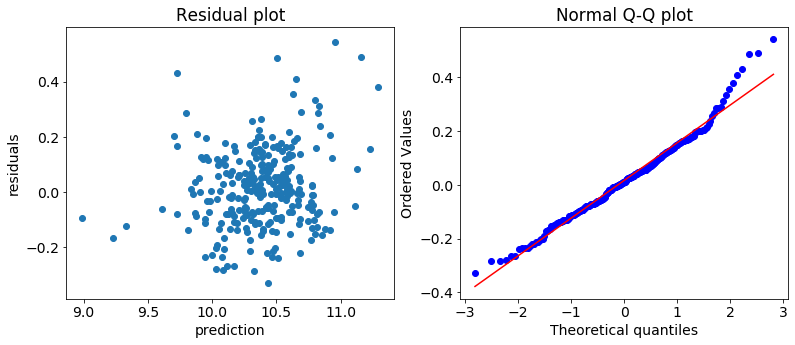

In [34]:
# ElasticNetCV search for optimal alpha and l1_ratio

en_model = optimize_ElasticNet(X_train, y_train, X_val, y_val)
sorted_coefs = feature_coefs(X, en_model) # sort coefficients by magnitude

en_model.fit(X_train, y_train)
predictions = en_model.predict(X_val)
residual_plots(y_val, predictions) # plot residuals and Q-Q plot
print("Number of features: %i"%(len(sorted_coefs)))

alpha range: [0.010000, 0.010000]
best alpha: 0.0100
l1_ratio: 0.5258
R^2: 0.8502
Adj. R^2: 0.8140
RMSE: 0.1413
Number of features: 66


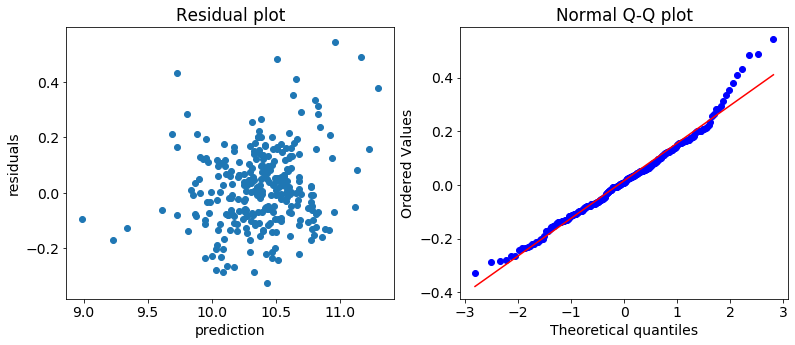

In [35]:
# increasing alpha with ElasticNet
en_model = optimize_ElasticNet(X_train, y_train, X_val, y_val, alphavec=[0.01])
sorted_coefs = feature_coefs(X, en_model) # sort coefficients by magnitude

en_model.fit(X_train, y_train)
predictions = en_model.predict(X_val)
residual_plots(y_val, predictions) # plot residuals and Q-Q plot
print("Number of features: %i"%(len(sorted_coefs)))

Text(0.5, 0, 'coefficients')

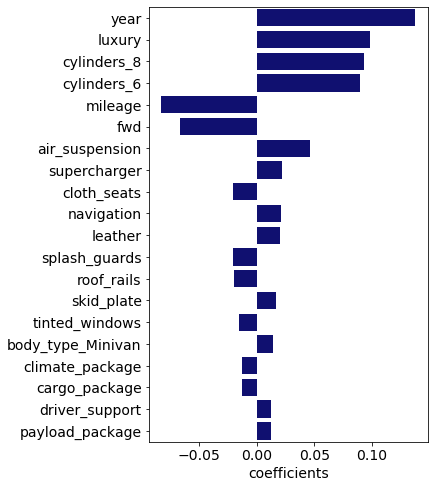

In [36]:
plt.figure(figsize=(5,8))
sc = sorted_coefs[:20]
sns.barplot(data=sc, y=sc.index, x=sc['coef'], color='navy')
plt.ylabel('')
plt.xlabel('coefficients')


## 5. Final model validation and results

In [37]:
# The lasso regularized model with increased alpha seems to be the most realistic so far, based on the residuals, 
# scoring, and fewer features for interpretability.

lasso_model_higher_reg = Lasso(alpha=higher_alpha, fit_intercept=True)
lasso_model_higher_reg.fit(X_train, y_train)

sorted_coefs = feature_coefs(X, lasso_model_higher_reg)
sorted_coefs.index.names = ['']
sorted_coefs = sorted_coefs.drop('abs_val', axis=1)
sorted_coefs['gain/loss per $1'] = np.round(sorted_coefs['price_ratio']-1,2)

print('Number of features: %i \n'%(len(sorted_coefs)))

R2 = cross_val_score(lasso_model_higher_reg, X_train, y_train, cv=5, scoring='r2').mean()
print('R^2: %.4f'%(R2))
print('Adj. R^2: %.4f \n'%(adj_r2(R2, X_train.shape[0], len(sorted_coefs))))

R2_test = lasso_model_higher_reg.score(X_test, y_test)
print('R^2 test: %.4f'%(R2_test))
print('Adj. R^2: %.4f'%(adj_r2(R2_test, X_test.shape[0], len(sorted_coefs))))


Number of features: 29 

R^2: 0.7926
Adj. R^2: 0.7830 

R^2 test: 0.8447
Adj. R^2: 0.8229


In [38]:
# Displaying final coefficients and corresponding estimated value compared to baseline features in USD

np.round(sorted_coefs[:20], 3)

,coef,price_ratio,gain/loss per $1
,,,
year,0.132,1.141,0.14
luxury,0.095,1.099,0.10
cylinders_8,0.093,1.097,0.10
cylinders_6,0.086,1.090,0.09
mileage,-0.076,0.927,-0.07
fwd,-0.069,0.934,-0.07
air_suspension,0.041,1.042,0.04
navigation,0.023,1.023,0.02
cloth_seats,-0.019,0.981,-0.02
